In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.data import imread
from skimage.morphology import label

In [2]:
test_img_dir = '/media/jun/data/ship/test_v2/'
model_path = './model.pb'

In [3]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img[0,:,:])
    return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

  # ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

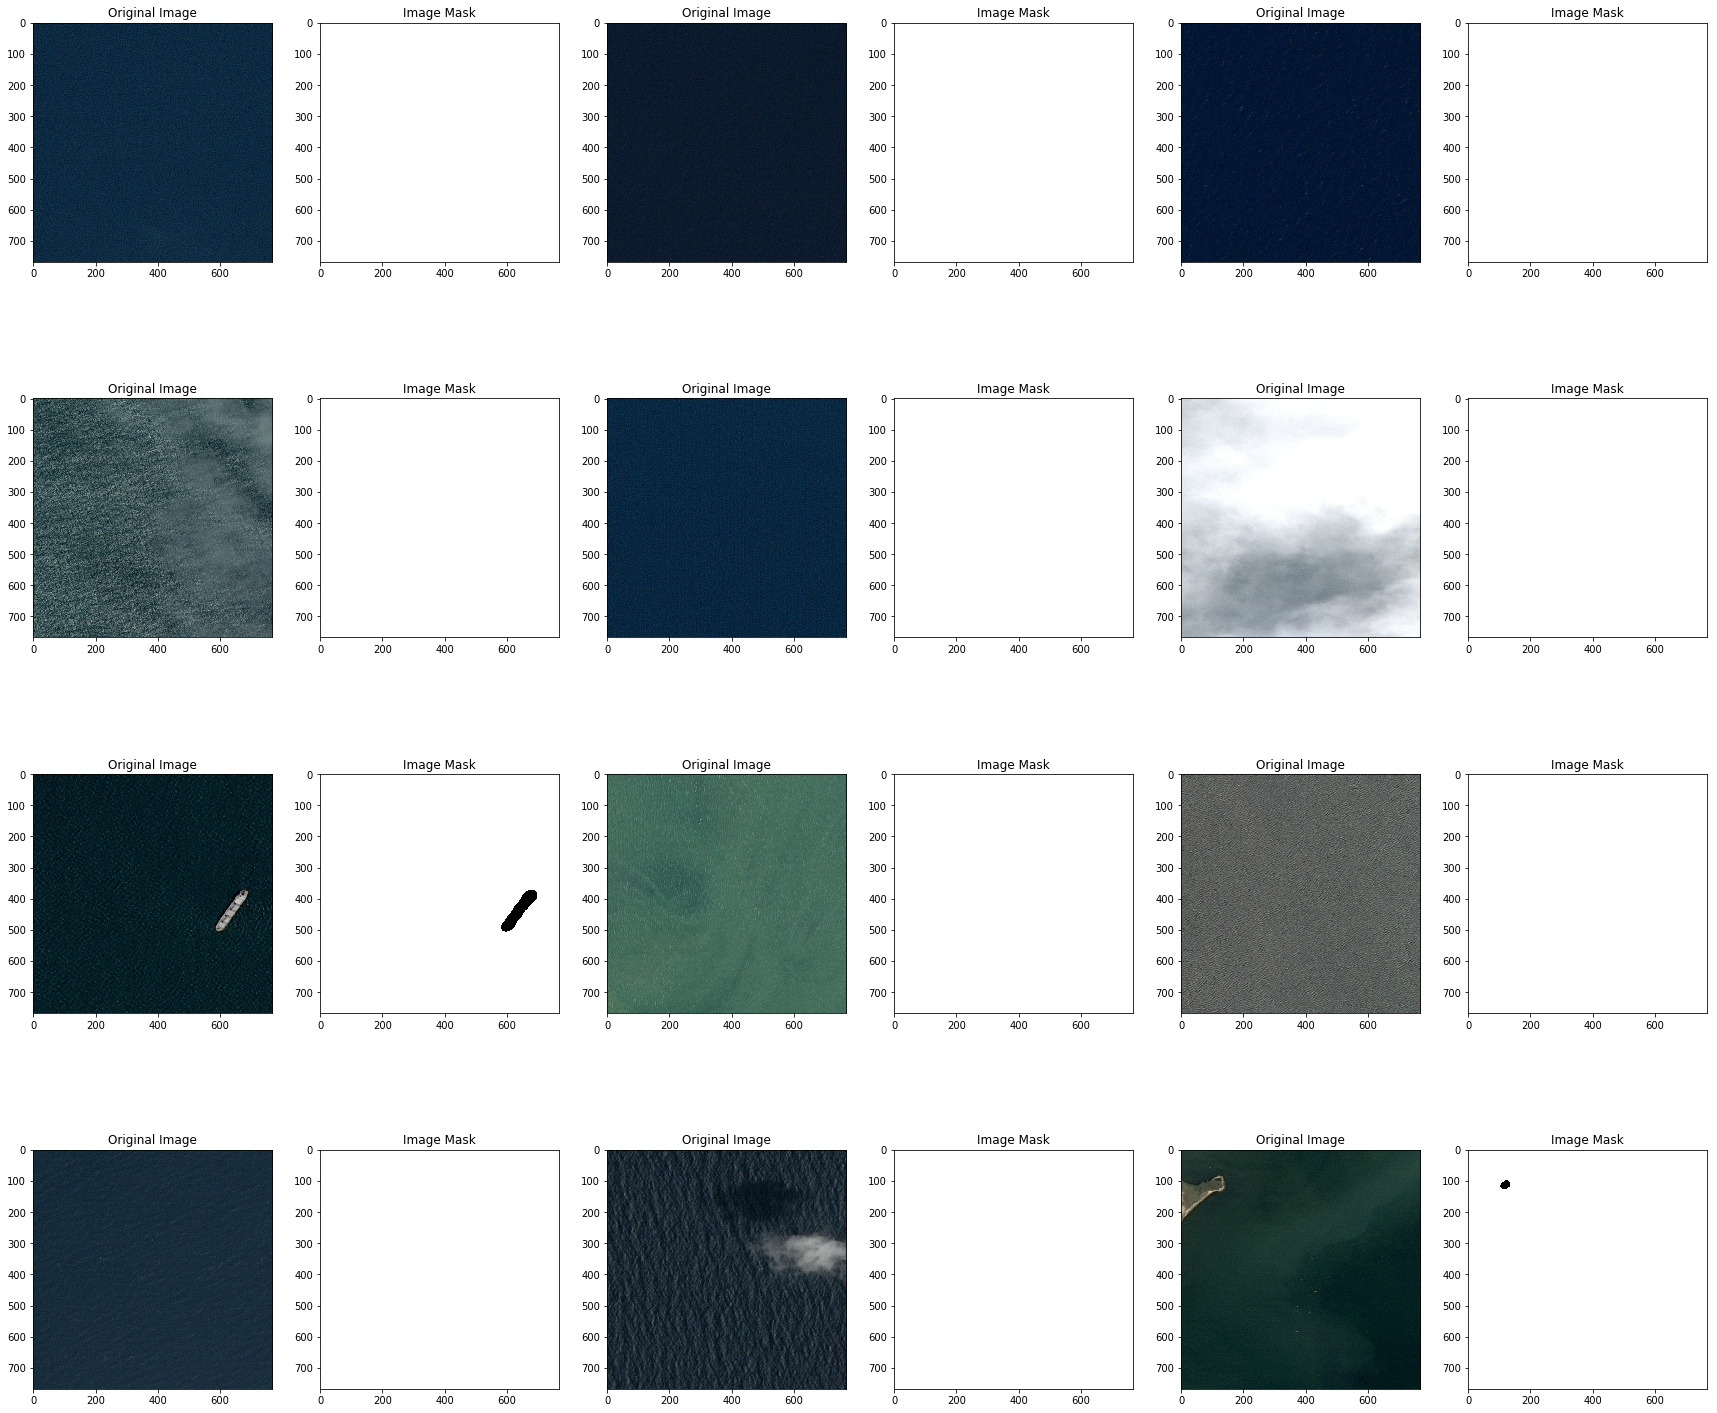

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 20))
plt.subplots_adjust(bottom=0.2, top=1.2)

g = tf.Graph()
with g.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.FastGFile(model_path, 'rb') as f:
        od_graph_def.ParseFromString(f.read())
        img_tensor, seg_pred= tf.import_graph_def(
                od_graph_def,
                return_elements=['ImageTensor:0', 'SemanticPredictions:0'])
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        pred_rows = []
        i=1
        for image_name in os.listdir(test_img_dir)[124:136]:
            test_img = imread(test_img_dir + image_name)
            plt.subplot(4, 6, i)
            plt.imshow(test_img, cmap='binary')
            plt.title('Original Image')
            test_img = np.expand_dims(test_img, 0)
            pred_mask = sess.run(seg_pred, {img_tensor: test_img})
            plt.subplot(4, 6, i+1)
            plt.imshow(pred_mask[0,:,:], cmap='binary')
            plt.title('Image Mask')
            i+=2
            rles = multi_rle_encode(pred_mask)
            if len(rles)>0:
                for rle in rles:
                    pred_rows += [{'ImageId': image_name, 'EncodedPixels': rle}]
            else:
                pred_rows += [{'ImageId': image_name, 'EncodedPixels': None}]
        submission_df = pd.DataFrame(pred_rows)[['ImageId', 'EncodedPixels']]
        submission_df.to_csv('submission.csv', index=False)

In [6]:
def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 1.0
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

In [9]:
test_df = pd.read_csv('./submission.csv')
test_gp = test_df.groupby('ImageId').sum()


In [10]:
test_gp

EncodedPixels
ImageId                                                         
151e85cf7.jpg                                                  0
1520db360.jpg  445161 12 445929 12 446694 18 447459 23 448227...
15239b2d3.jpg                                                  0
1525a94c0.jpg                                                  0
15278512c.jpg                                                  0
1527b13f4.jpg                                                  0
152c4b826.jpg  79219 7 79987 7 80753 11 81518 15 82286 15 830...
59661982b.jpg                                                  0
596a5f242.jpg                                                  0
596d3c0a8.jpg                                                  0
597444782.jpg                                                  0
59760b138.jpg                                                  0

In [15]:
test_df

ImageId                                      EncodedPixels
0   59661982b.jpg                                                NaN
1   596a5f242.jpg                                                NaN
2   596d3c0a8.jpg                                                NaN
3   597444782.jpg                                                NaN
4   59760b138.jpg                                                NaN
5   151e85cf7.jpg                                                NaN
6   1520db360.jpg  445161 12 445929 12 446694 18 447459 23 448227...
7   15239b2d3.jpg                                                NaN
8   1525a94c0.jpg                                                NaN
9   15278512c.jpg                                                NaN
10  1527b13f4.jpg                                                NaN
11  152c4b826.jpg  79219 7 79987 7 80753 11 81518 15 82286 15 830...

In [16]:
test_list = test_df['ImageId'].tolist()

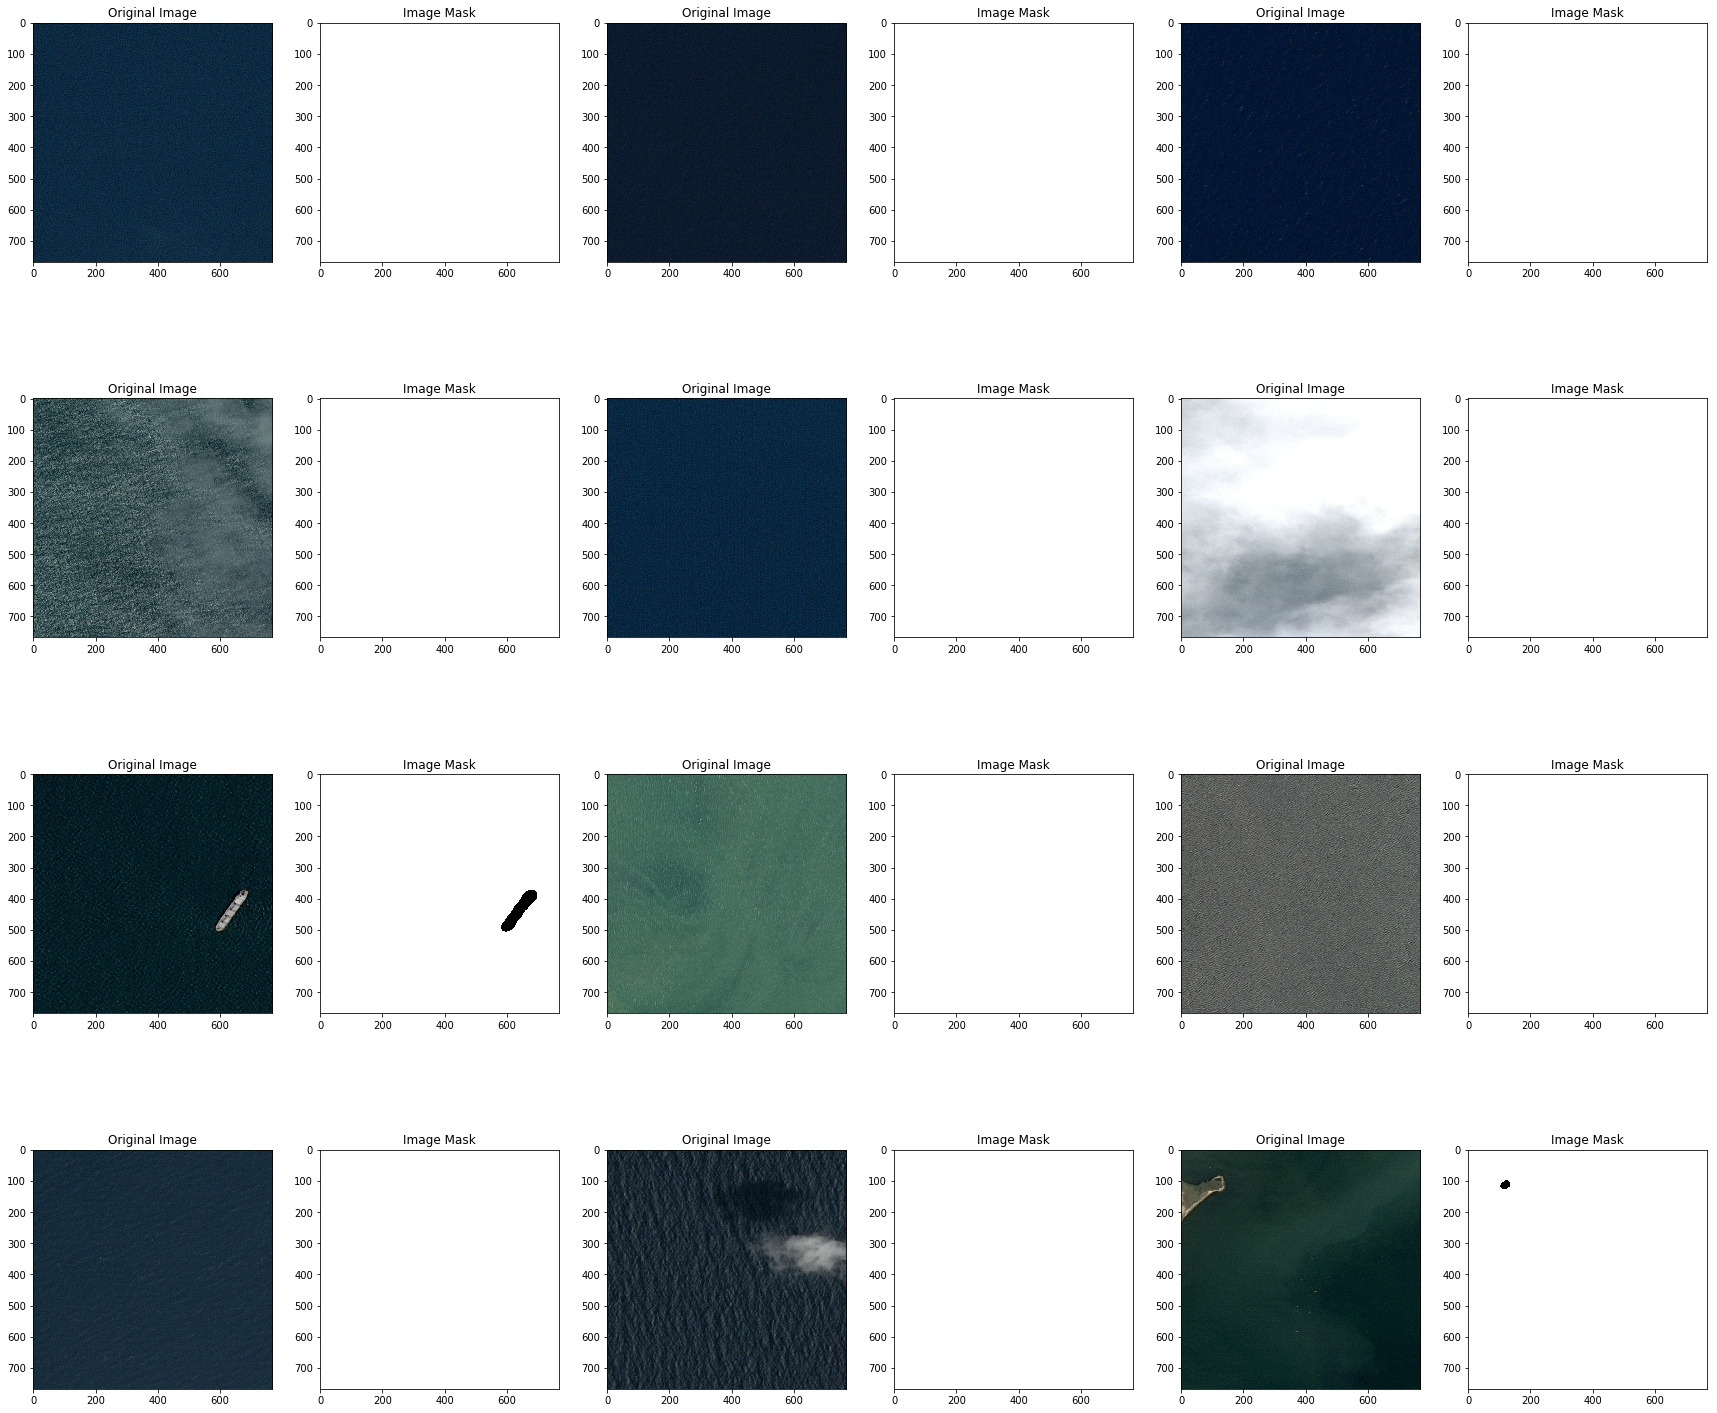

In [22]:
plt.figure(figsize=(30, 20))
plt.subplots_adjust(bottom=0.2, top=1.2)
i=1
for name in test_list:
    test_img = imread(test_img_dir + name)
    plt.subplot(4, 6, i)
    plt.imshow(test_img, cmap='binary')
    plt.title('Original Image')
    
    mask_list = test_df['EncodedPixels'][test_df['ImageId'] == name].tolist()
    seg_mask = np.zeros((768, 768, 1))
    for item in mask_list:
      rle_list = str(item).split()
      tmp_mask = rle_to_mask(rle_list, (768, 768))
      seg_mask[:,:,0] += tmp_mask
    plt.subplot(4, 6, i+1)
    plt.imshow(seg_mask[:,:,0], cmap='binary')
    plt.title('Image Mask')
    i=i+2

Text(0.5,1,'Original Image')

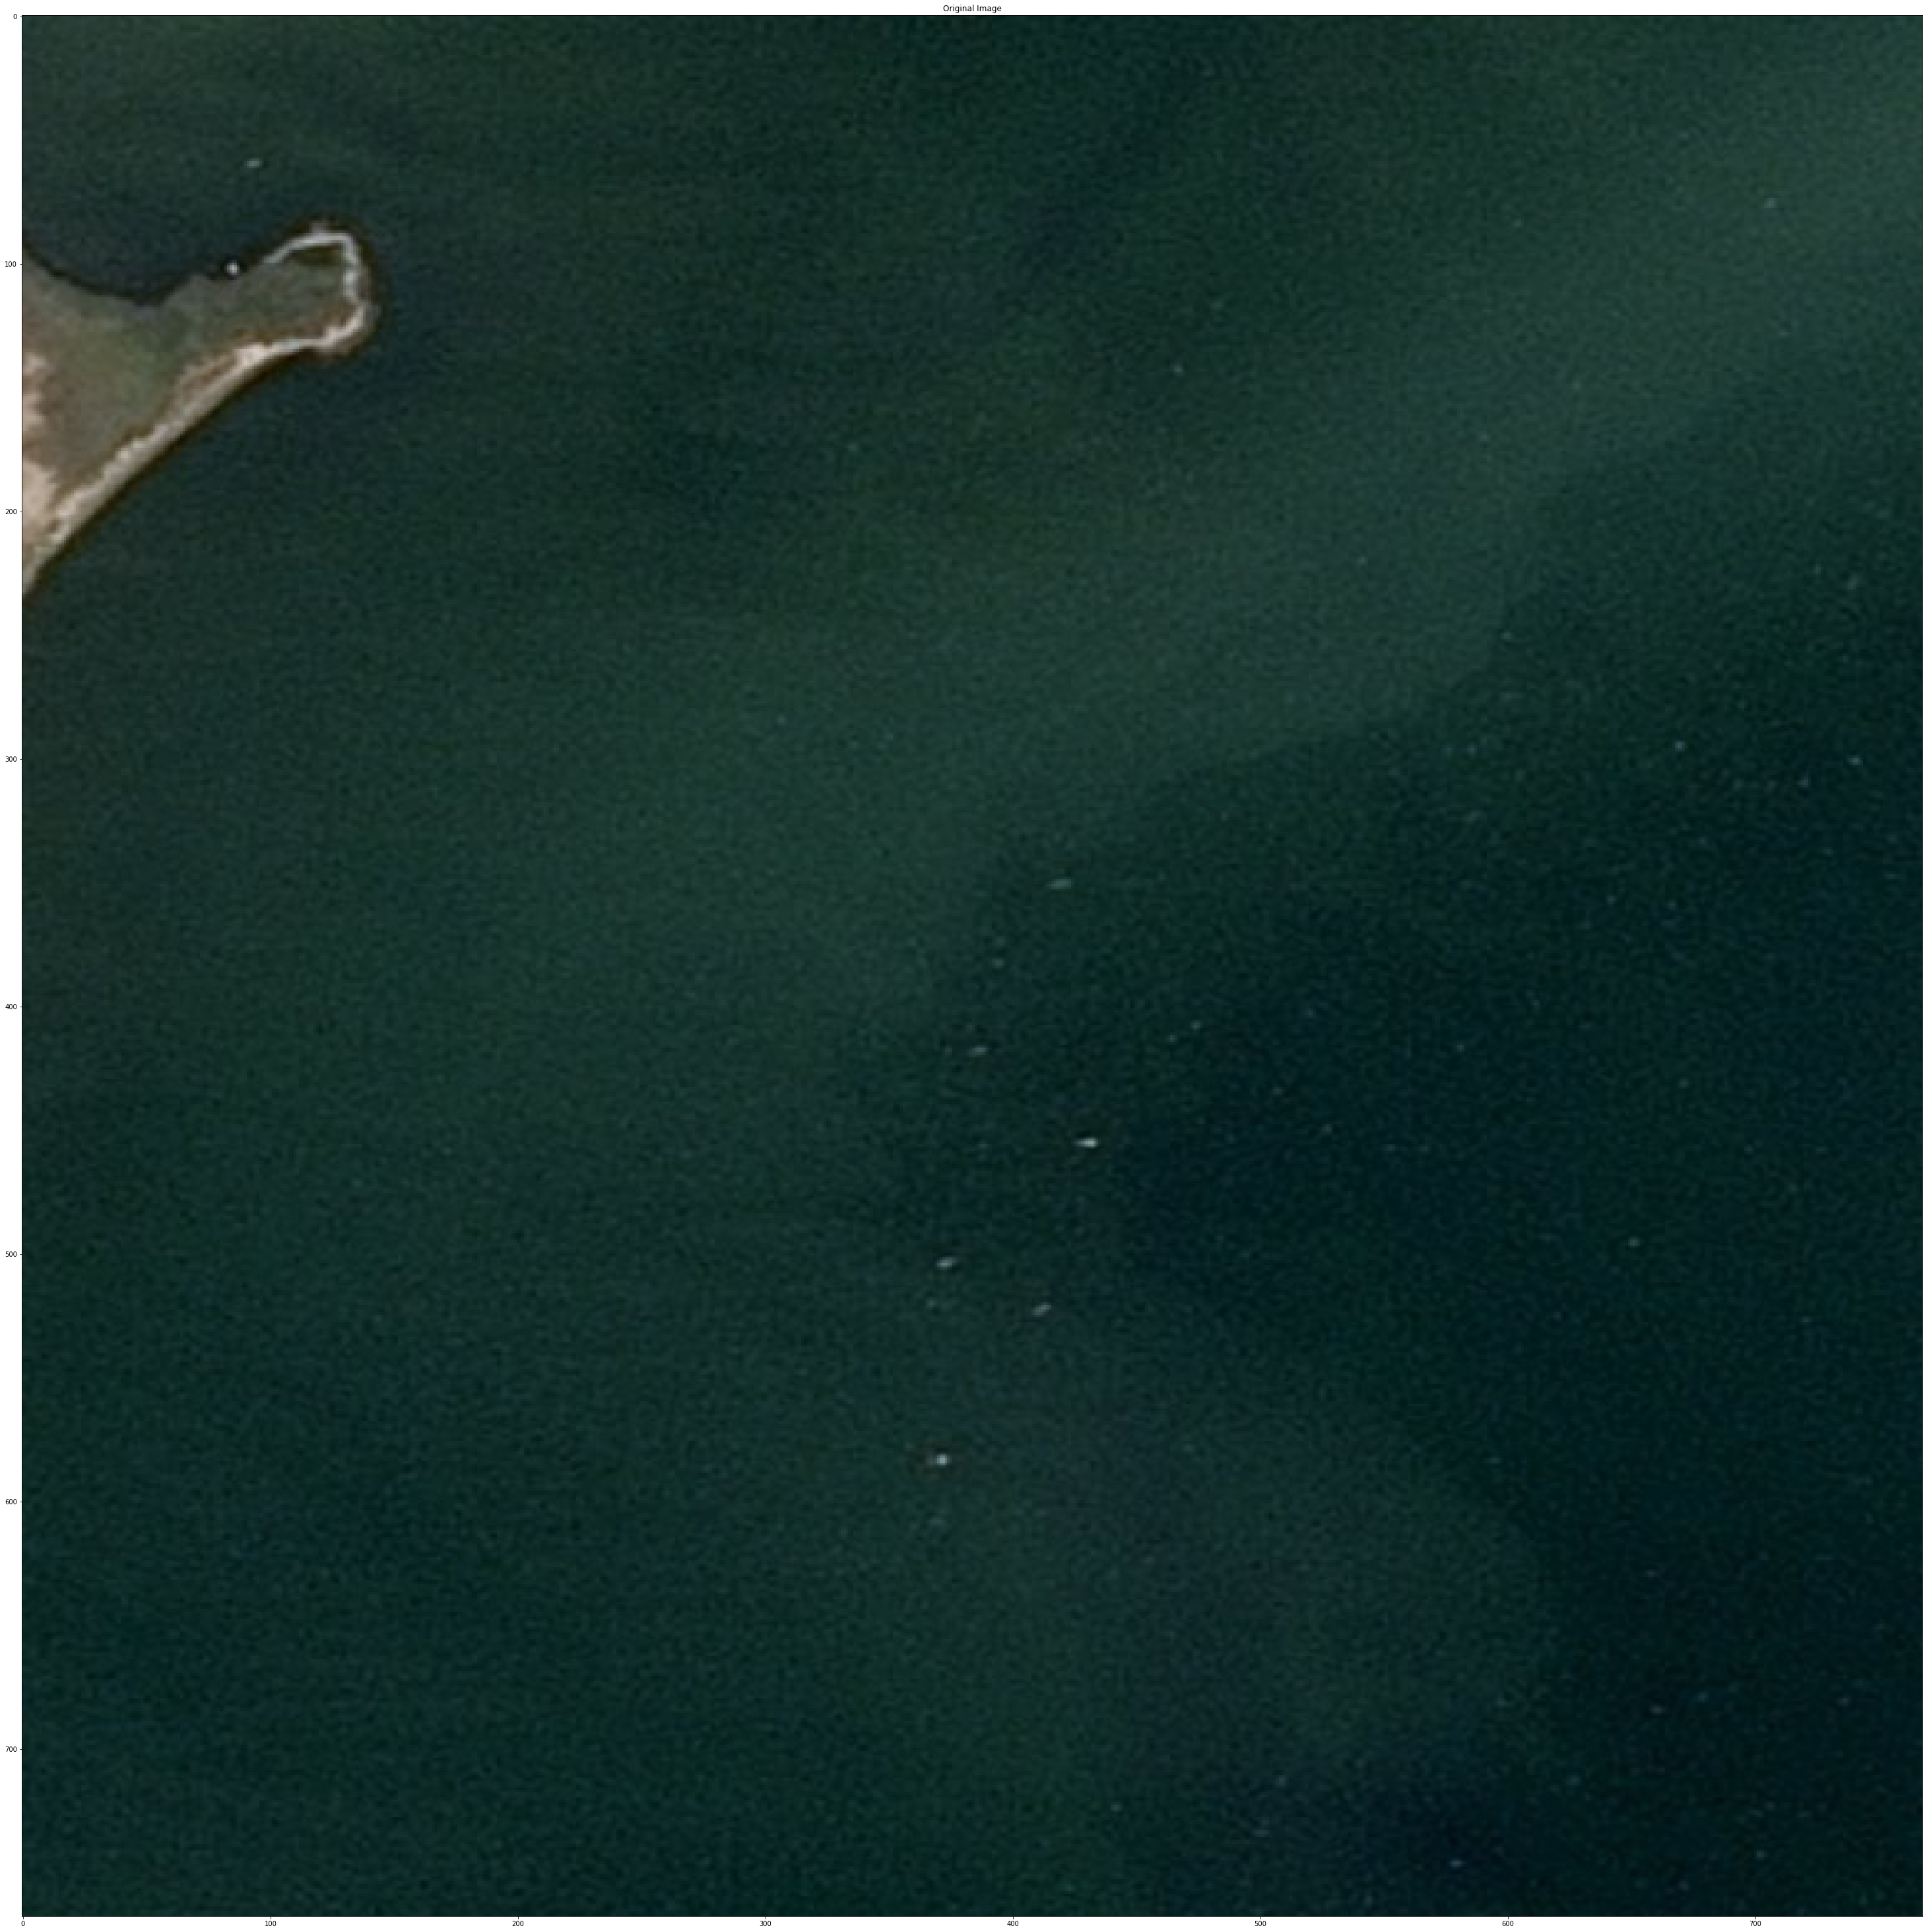

In [25]:
plt.figure(figsize=(60, 40))
plt.subplots_adjust(bottom=0.2, top=1.2)

test_img = imread(test_img_dir + test_list[-1])

plt.imshow(test_img, cmap='binary')
plt.title('Original Image')
